# Machine Learning Project - Kickstarter Data Set
## EDA Notebook
*Contributor: Max Langer, René Ebrecht, Jens Reich*

This is the very first project where we build a machine learning model from scratch based on an unknown dataset.
The dataset includes data from Kickstarter projects from the years 2009 to 2019.

Our goal is to help our (fictional) stackholder, PPC Consultants with a model that can predict whether a Kickstarter project will be successful or not. 
PPC Consultants advises potential project creators (PPCs) with their projects to get them off the ground as successfully as possible.
Therefore, the value of our data product (the predictive model) is to show opportunities, save time, and in the end make money for both PPC consultants and PPCs.

In [1]:
# Import the organization modules
import pandas as pd
import numpy as np
import datetime
# Import module to ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Import the plot modules
import matplotlib.pyplot as plt
import seaborn as sns
# Import own scripts
from scripts.data_cleaning import (
    read_all_csvs, 
    clean_data,
    convert_to_datetime,
    get_year_month_day,
    clean_target,
    create_csv
    )

In [2]:
# Create data frame from all single CSV files
df = read_all_csvs()

In [3]:
# Clean the data
df_clean = clean_data(df)

In [4]:
# Get a look at the data frame
df_clean.head()

,goal,state,days_prelaunch,days_total,project_name_len,creator_name_len,blurb_len,country_AT,country_AU,country_BE,...,category_sub_wearables,category_sub_weaving,category_sub_web,category_sub_webcomics,category_sub_webseries,category_sub_woodworking,category_sub_workshops,category_sub_world music,category_sub_young adult,category_sub_zines
0,200.0,successful,4,49,4,6,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,400.0,successful,5,25,5,9,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27224.0,successful,9,39,9,13,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40000.0,successful,3,45,5,3,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000.0,failed,2,32,4,11,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
df_clean.shape

NameError: name 'df_clean' is not defined

In [5]:
# Set the notebook style 
sns.set_theme(context='notebook', style='darkgrid')
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":300})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(6,3)})

Let's clean the data for the EDA.

In [6]:
# Remove the duplicates
df.drop_duplicates(subset='id', inplace=True)
# Drop all columns with more than 50% of the observations missing
df = df[[column for column in df if df[column].count() / len(df) >= 0.5]]
# Convert the time columns to datetime types
df = convert_to_datetime(df, ['created_at', 'state_changed_at', 'deadline', 'launched_at'])
# Clean the target variable
df = clean_target(df)

Now we can have a look at the project amount over the 10 year span the data set covers.

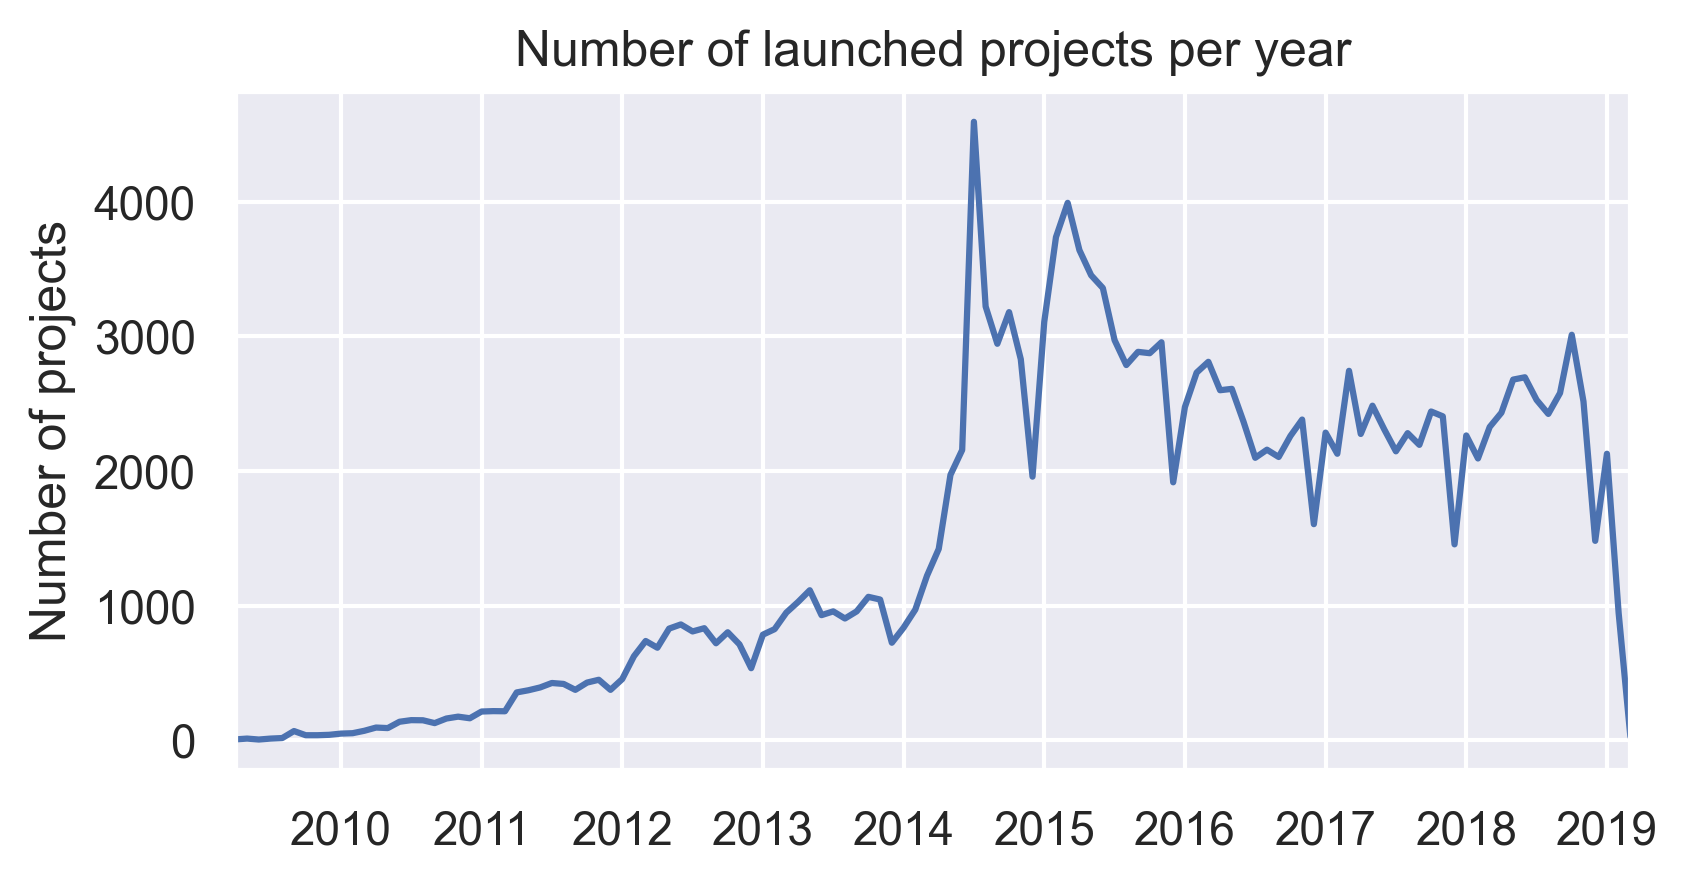

In [7]:
# .set_index sets the launched_at as index
# .resample aggregates time series data in this case by month (M), Y would be year
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
df.set_index('launched_at')['category'].resample('M').count().plot()
plt.xlabel('')
plt.ylabel('Number of projects')
plt.title('Number of launched projects per year');

In [8]:
# Get the years, months and days as separate columns
df_year_split = get_year_month_day(df, ['created_at', 'state_changed_at', 'deadline', 'launched_at'])
df_year_split.head()

,backers_count,blurb,category,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,...,state_changed_at_day,state_changed_at_weekday,deadline_year,deadline_month,deadline_day,deadline_weekday,launched_at_year,launched_at_month,launched_at_day,launched_at_weekday
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,USD,...,8,5,2014,2,8,5,2013,12,25,2
1,97,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2259,US,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,USD,...,5,1,2019,3,5,1,2019,2,13,2
2,88,Helping a community come together to set the s...,"{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",29638,US,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,USD,...,1,3,2016,12,1,3,2016,11,1,1
3,193,Every revolution starts from the bottom and we...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",49158,IT,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,USD,...,8,5,2018,12,8,5,2018,10,27,5
4,20,Learn to build 10+ Applications in this comple...,"{""id"":51,""name"":""Software"",""slug"":""technology/...",549,US,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,USD,...,8,2,2015,4,8,2,2015,3,9,0


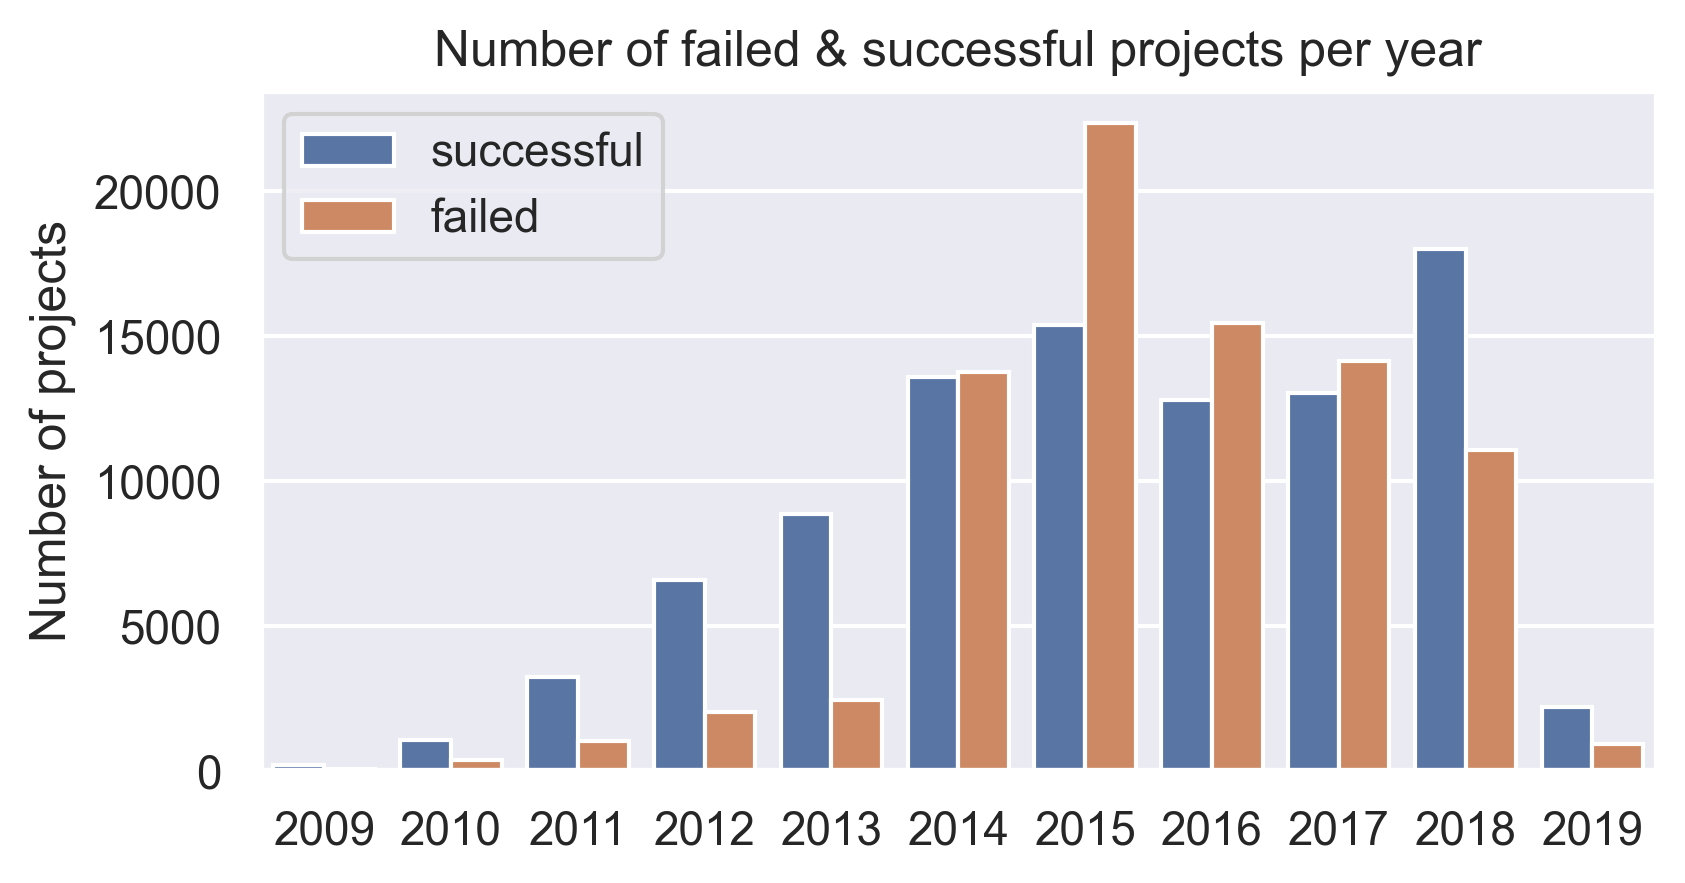

In [9]:
# Plot the amount of successful and failed projects over the years.
ax = sns.countplot(data=df_year_split, x='launched_at_year', hue='state')
ax.set(
    title='Number of failed & successful projects per year',
    xlabel=None,
    ylabel='Number of projects')
plt.legend();

In [13]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,...,state_changed_at_day,state_changed_at_weekday,deadline_year,deadline_month,deadline_day,deadline_weekday,launched_at_year,launched_at_month,launched_at_day,launched_at_weekday
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,USD,...,8,5,2014,2,8,5,2013,12,25,2
1,97,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2259,US,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,USD,...,5,1,2019,3,5,1,2019,2,13,2
2,88,Helping a community come together to set the s...,"{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",29638,US,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,USD,...,1,3,2016,12,1,3,2016,11,1,1
3,193,Every revolution starts from the bottom and we...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",49158,IT,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,USD,...,8,5,2018,12,8,5,2018,10,27,5
4,20,Learn to build 10+ Applications in this comple...,"{""id"":51,""name"":""Software"",""slug"":""technology/...",549,US,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,USD,...,8,2,2015,4,8,2,2015,3,9,0


In [ ]:
# Assessing skewed distributions
cols_to_log = ['creation_to_launch_days', 'name_length', 'usd_goal']
df[cols_to_log].hist(figsize=(8,6));